In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
# nltk.download('punkt')   Package punkt is already up-to-date!
# nltk.download("stopwords")    Package stopwords is already up-to-date!


from nltk.stem import WordNetLemmatizer
# nltk.download('wordnet')  Package wordnet is already up-to-date!

from wordcloud import WordCloud,STOPWORDS

# IMPORT FUZZYWUZZY
from fuzzywuzzy import fuzz

from sklearn.manifold import TSNE

C:\ProgramData\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning:

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning



In [77]:
Qd = pd.read_csv(r"Z:\DS DATA\train.csv")
Qd.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


<h3>Preprocessing the Text</h3>
<p><b>-Preprocessing</b>:
    <ul style="trangle">
        <li>Removing Html tags</li>
        <li>Removing Punchutations</li>
        <li>Performing Stemming</li>
        <li>Removing Stopwords</li>
        <li>Expanding contraction etc...</li>
    </ul>
</p>

In [78]:

def preprocess(x):
    x=re.sub("  *"," ",re.sub("<.*?>"," ",str(x).lower()))
    
#     x=re.sub("  *"," ",re.sub('<[a-zA-Z]*>|</[a-zA-Z]*>',' ',str(x))).lower()
    x=x.replace("%","percent").replace("$","dollar").replace("₹","rupees").replace("rs","rupees").replace(
    "i'm","i am").replace("don't","do not").replace("&","and").replace("we're","we are").replace("you're","you are").replace(
        "they're","they are").replace("he's","he is").replace("have't","have not").replace(
        "has't","has not").replace("is't","is not").replace("didn't","did not").replace("he'll","he will").replace(
    "she'll","she will").replace("it'll","it will").replace(',000',"k").replace("000,000","m").replace("'ve","have").replace('000',"k").replace("000000","m")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    x=re.sub("[^a-z0-9-]"," ",x)

    return  x
        
Qd["question1"] = Qd["question1"].apply(preprocess)
Qd["question2"] = Qd["question2"].apply(preprocess)
Qd.head()


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,1,3,4,what is the story of kohinoor koh-i-noor dia...,what would happen if the indian government sto...,0
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0


In [80]:
LEMATIZE = WordNetLemmatizer()
STOP_WORDS=stopwords.words("english")

def lematize(x):
    token=word_tokenize(x)

    words = set([word for word in token if word not in STOP_WORDS])
    
    stopwords = set([word for word in token if word in STOP_WORDS])
   
    lema = [LEMATIZE.lemmatize(word) for word in words ]
   
    filtered = stopwords.union(lema)
    return " ".join(filtered)

Qd["question1"] = Qd["question1"].apply(lematize)
Qd["question2"]=Qd["question2"].apply(lematize)


In [99]:
def emptly(x):
    if len(str(x['question1']))<=6:
        x['question1']=""
    if len(str(x['question2']))<=6:
        x['question2']=""
    if x["is_duplicate"]==0 and (x['question1']=="  " or x['question2']=="  "):
        x['is_duplicate']=1
        
    if x['question1']==" " or x['question2']==" ":
        print("yes")
    return x

Qd = Qd.apply(emptly,axis=1)

# ---------------------------------------------------------------------------------

# count1=  58 
#  count2=  25 
#  both=   3 
#  count00=   14
# 0    255027
# 1    149263
# ----------------------------------------------------------------------------
# count1=  63 
#  count2=  28 
#  both=   3 
#  count00=   86
# 0    254941
# 1    149349

<h3>Important Terms</h3><br>
<b>-Token-: </b>Each word after splitting the sentence is token<br>
<b>-Stop_Word-: </b>Stops word that are in nltk<br>
<b>-Words-: </b>token that is not in stopwords<br>
<h2>Feature Extraction</h2><br>
<b>Commom_word_Count_Min (cwc_min) </b>length of Intersection of Q1 and Q2 divide by Minimum length of Q1 and Q2 word<br>
<b>Commom_word_Count_Max (cwc_max) </b>length Intersection of Q1 and Q2 divide by Maximum length of Q1 and Q2 words<br>
<b>Commom_StopWord_Count_min (csc_min) </b>length Intersection of Q1 and Q2 divide by Minimum length of Q1 and Q2 stopwords<br>
<b>Commom_StopWord_Count_Max (cwc_max) </b>length Intersection of Q1 and Q2 divide by Maximum length of Q1 and Q2 stopwords<br>
<b>Commom_Token_Count_Min (ctc_min) </b>length Intersection of Q1 and Q2 divide by Minimum length of Q1 and Q2 tokenwords<br>
<b>Commom_Token_Count_Max (ctc_max) </b>length Intersection of Q1 and Q2 divide by Maximum length of Q1 and Q2 tokenwords<br>
<b>First_token_Common (fw_com ) </b>checking common token in both Questions at first place<br>
<b>Last_token_Common (lw_com) </b>checking common token in both Questions at last place<br>
<b>Absolute difference(abs_diff) </b>Absolute difference b/w length of Q1 and Q2 token<br>
<b>Middle of both question (ratio) </b>middle value of both(Q1+Q2) question<br>

In [107]:
# computing common_word_count_min cwc_min
SAFE_DIV = 0.0001
def extract_features(x):
    
    global SAFE_DIV
    q1_token=word_tokenize(x["question1"])
    q2_token=word_tokenize(x["question2"])
    
    q1_words = set([word for word in q1_token if word not in STOP_WORDS])
    q2_words = set([word for word in q2_token if word not in STOP_WORDS])
    
    q1_stops = set([word for word in q1_token if word in STOP_WORDS])
    q2_stops = set([word for word in q2_token if word in STOP_WORDS])
    
    common_word_count = len(q1_words.intersection(q2_words))
    common_stop_count = len(q1_stops.intersection(q2_stops))
    common_token_count = len(set(q1_token).intersection(set(q2_token)))
    
    cwc_min=0
    cwc_max=0
#     MIN MAX FOR WORDS
    cwc_max = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)  # MAX
    cwc_min = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV) # MIN

#     MIN MAX FOR STOP WORDS
    csc_min=0
    csc_max=0
    csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)  # MAX
    csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV) # MIN
    
#     MIN MAX FOR TOKENS
    ctc_min=0
    ctc_max=0
    ctc_max = common_token_count / (max(len(q1_token), len(q2_token)) + SAFE_DIV)  # MAX
    ctc_min = common_token_count / (min(len(q1_token), len(q2_token)) + SAFE_DIV) # MIN

#     LAST WORD FIRST WORD DIFF. LAST WORD DIFF. ABSOLUTE DIFF. RATION B/W TOKENS
    if len(q1_token)<=0 or len(q2_token)<=0:
        fw_com =0
        lw_com =0
    else:
        fw_com = int(q1_token[0]==q2_token[0])
        lw_com = int(q1_token[-1]==q2_token[-1])
    abs_diff= abs(len(q1_token)-len(q2_token))
    ratio = (len(q1_token)+len(q2_token)) / 2
    
    return cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, fw_com, lw_com, abs_diff, ratio
    
Qd[["cwc_min","cwc_max","csc_min","csc_max","ctc_min","ctc_max","fw_com","lw_com","abs_diff","ratio"]] = Qd.apply(extract_features,axis=1,result_type="expand")


In [133]:
def fuzzyfeatures(x):
    token_set_ratio = fuzz.token_set_ratio(x["question1"],x["question2"])
    token_sort_ratio = fuzz.token_sort_ratio(x["question1"],x["question2"])
    fuzz_ratio = fuzz.QRatio (x["question1"],x["question2"])
    partial_ratio = fuzz.partial_ratio(x["question1"],x["question2"])

    return token_set_ratio,token_sort_ratio,fuzz_ratio,partial_ratio

Qd[["token_set_ratio","token_sort_ratio","fuzz_ratio","partial_ratio"]]=Qd.apply(fuzzyfeatures,axis=1,result_type='expand')


In [134]:
Qd.head()
# Qd.info()

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,fw_com,lw_com,abs_diff,ratio,token_set_ratio,token_sort_ratio,fuzz_ratio,partial_ratio
0,0,1,2,invest in the market guide to step by india is...,invest in the market guide to step by is what ...,0,0.999980,0.833319,0.999983,0.999983,0.999991,0.916659,1.0,1.0,1.0,11.5,100,94,94,88
1,1,3,4,diamond story kohinoor of the koh-i-noor is what,diamond government kohinoor back stole the hap...,0,0.749981,0.333330,0.666644,0.499988,0.624992,0.416663,1.0,0.0,4.0,10.0,86,65,62,60
2,2,5,6,a i how connection of the using speed can whil...,increased dns hacking speed can internet how t...,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,0.0,4.0,12.0,63,63,45,52
3,3,7,8,can lonely why it i how am very solve mentally,when find remainder the by 24 is math divided 23,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,10.0,28,28,26,28
4,4,9,10,oxide which dissolve in and di quikly sugar ca...,which in survive salt fish water would,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,0.0,6.0,10.0,67,47,45,45


In [104]:
df_duplicate = Qd[Qd['is_duplicate']==1]
df_noduplicate = Qd[Qd['is_duplicate']==0]

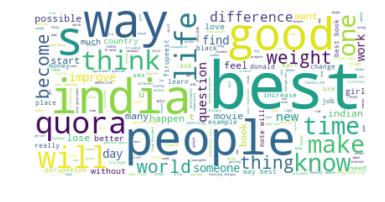

In [105]:
q1=np.dstack([df_duplicate["question1"],df_duplicate["question2"]]).flatten()
wordcloud_spam = WordCloud(background_color="white").generate(" ".join(q1))
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis("off")
plt.show()


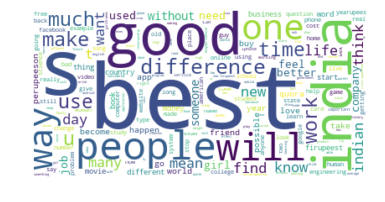

In [106]:
q1=np.dstack([df_noduplicate["question1"],df_noduplicate["question2"]]).flatten()
wordcloud_spam = WordCloud(background_color="white").generate(" ".join(q1))
# # Lines 2 - 5
# plt.figure(figsize = (10,10))
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis("off")
plt.show()


In [135]:
from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = Qd[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'fw_com', 'lw_com' , 'abs_diff' , 'ratio' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'partial_ratio' ]])
y = dfp_subsampled['is_duplicate'].values





In [136]:
from sklearn.manifold import TSNE
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.270s...
[t-SNE] Computed neighbors for 5000 samples in 0.868s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.119465
[t-SNE] Computed conditional probabilities in 0.464s
[t-SNE] Iteration 50: error = 81.1286087, gradient norm = 0.0466588 (50 iterations in 3.706s)
[t-SNE] Iteration 100: error = 70.0300827, gradient norm = 0.0085095 (50 iterations in 2.237s)
[t-SNE] Iteration 150: error = 68.2944565, gradient norm = 0.0048681 (50 iterations in 2.105s)
[t-SNE] Iteration 200: error = 67.5355377, gradient norm = 0.0033108 (50 iterations in 2.089s)
[t-SNE] Iteration 250: error = 67.0968704, gradient norm = 0.0033370

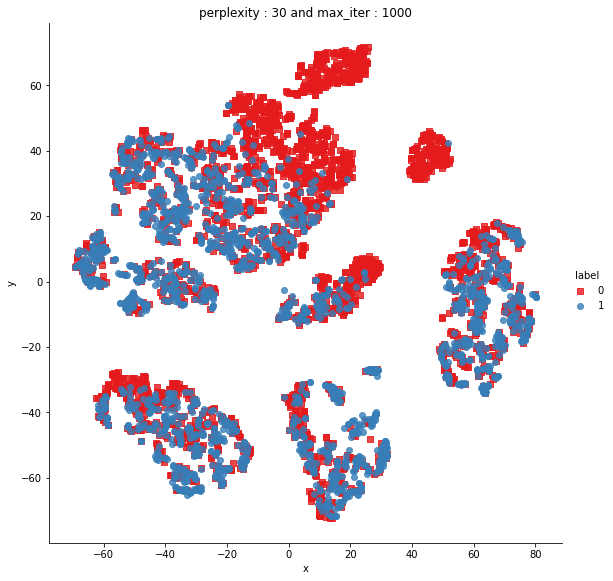

In [137]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [151]:
Qd.to_csv(r"Z:\DS DATA\ft2_df.csv")
print("successfuly")

successfuly


In [1]:
# # 3D VISUALIZATION
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

NameError: name 'tsne3d' is not defined